# Match known hurricanes

In [1]:
import pandas as pd
import numpy as np
import xarray as xr

import os
import re

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib
import matplotlib.pyplot as plt
from descartes.patch import PolygonPatch

import tqdm

% matplotlib inline

In [2]:
import tqdm

In [3]:
# ! pip install fuzzywuzzy[speedup]

In [4]:
import fuzzywuzzy as fw

In [5]:
from fuzzywuzzy import process, fuzz

In [6]:
import geopandas as gpd

In [7]:
gpd.__version__

'1.0.0.dev+141.ge925363'

Make sure your version can handle vectorized operations. If in doubt:

```conda install -c conda-forge/label/dev geopandas```

# Load data with assigned region IDs

In [8]:
df = pd.read_csv('DataVizDisasterSummariesFV12.19.2016.with_region_codes.csv', index_col=0)

In [9]:
df.head()

,Disaster Number,Year,Region,Region Number,State Abbreviation,State,County,Declaration Date,Disaster Type,Incident Type,Title,Incident Begin Date,Incident End Date,Disaster Close Out Date,fips,state_fips,county_fips,school_district
0,3,1953,Region VI,6,LA,Louisiana,Statewide,5/29/53,DR,Flood,FLOOD,5/29/53,5/29/53,2/1/60,22000.0,22,NaN,NaN
1,1,1953,Region IV,4,GA,Georgia,Statewide,5/2/53,DR,Tornado,TORNADO,5/2/53,5/2/53,6/1/54,13000.0,13,NaN,NaN
2,4,1953,Region V,5,MI,Michigan,Statewide,6/2/53,DR,Tornado,TORNADO,6/2/53,6/2/53,2/1/56,26000.0,26,NaN,NaN
3,15,1954,Region IX,9,CA,California,Statewide,2/5/54,DR,Flood,FLOOD & EROSION,2/5/54,2/5/54,9/1/57,6000.0,6,NaN,NaN
4,25,1954,Region I,1,CT,Connecticut,Statewide,9/17/54,DR,Hurricane,HURRICANES,9/17/54,9/17/54,1/1/57,9000.0,9,NaN,NaN


In [10]:
len(df)

45991

# Filter by Region Number

In [11]:
df[['Region Number', 'State Abbreviation']].groupby('Region Number').apply(lambda x: x['State Abbreviation'].unique())

Region Number
1                                     [CT, MA]
2                         [NY, PR, NJ, VI, ME]
3                 [WV, MD, PA, VA, NH, DE, DC]
4         [GA, NC, FL, MS, KY, SC, RI, TN, AL]
5                 [MI, IL, OH, IN, MN, VT, WI]
6                         [LA, OK, TX, NM, AR]
7                             [MO, IA, KS, NE]
8                     [SD, CO, ND, MT, WY, UT]
9     [CA, NV, GU, HI, FM, AS, PW, AZ, MP, MH]
10                            [ID, WA, OR, AK]
dtype: object

Remove Pacific coast & Mountain states/territories. *Note that this removes overseas territories that are succeptible to hurricanes, but are not in our other datasets.*

In [12]:
df = df[~np.isin(df['Region Number'], [8, 9, 10])]

In [13]:
df = df[((df['State Abbreviation'] != 'PR') & (df['State Abbreviation'] != 'VI'))]

In [14]:
len(df)

38755

# Filter by reported incident type

In [15]:
df['Incident Type'].unique()

array(['Flood', 'Tornado', 'Hurricane', 'Other', 'Severe Storm',
       'Drought', 'Fire', 'Toxic Substances', 'Severe Ice Storm',
       'Freezing', 'Snow', 'Coastal Storm', 'Fishing Losses',
       'Mud/Landslide', 'Human Cause', 'Terrorist', 'Earthquake',
       'Chemical'], dtype=object)

In [16]:
sort_of_plausible_hurricane_categories = [
    'Flood', 'Hurricane', 'Other', 'Severe Storm',
    'Typhoon', 'Dam/Levee Break', 'Severe Ice Storm',
    'Coastal Storm', 'Mud/Landslide']

In [17]:
plausibly_hurricanes = df[np.isin(
    df['Incident Type'],
    sort_of_plausible_hurricane_categories)]

In [18]:
len(plausibly_hurricanes)

30870

In [19]:
plausibly_hurricanes[plausibly_hurricanes['Incident Type'] == "Other"].Title.unique()

array(['WIND STORM', 'SEVERE WEATHER CONDITIONS', 'HIGH WINDS',
       'MAJOR WATER MAIN BREAK',
       'DEBRUCE GRAIN ELEVATOR EXPLOSION  (SEDGWICK CTY)',
       'WEST NILE VIRUS', 'LOSS OF THE SPACE SHUTTLE COLUMBIA',
       'LOSS OF SPACE SHUTTLE COLUMBIA', 'POWER OUTAGE',
       'BRIDGE COLLAPSE', '56TH PRESIDENTIAL INAUGURATION',
       'WATER MAIN BREAK', 'EXPLOSION'], dtype=object)

In [20]:
plausibly_hurricane_other_type_names = [
    'WIND STORM', 'SEVERE WEATHER CONDITIONS',
    'TIDAL WAVE', 'TIDAL WAVES', 'HIGH WINDS',
    'MAJOR WATER MAIN BREAK',
    'POWER OUTAGE',
    'BRIDGE COLLAPSE',
    'WATER MAIN BREAK', 'EXPLOSION'
]

In [21]:
plausibly_hurricanes = plausibly_hurricanes[(
    (plausibly_hurricanes['Incident Type'] != "Other")
    | (np.isin(plausibly_hurricanes['Title'], plausibly_hurricane_other_type_names)))]

In [22]:
declaration_date = pd.to_datetime(plausibly_hurricanes['Declaration Date'], format='%m/%d/%y')
declaration_date[declaration_date.dt.year > 2020] = declaration_date - np.timedelta64(100, 'Y')
plausibly_hurricanes['declaration_date'] = declaration_date

In [23]:
len(plausibly_hurricanes)

30690

# Assign known storms

### load in ibtracs

In [24]:
ibtracs = xr.open_dataset(
    '/gcs/rhg-data/impactlab-rhg/coastal/storm_tracks/Allstorms.ibtracs_wmo.v03r10.nc')

In [25]:
ibtracs['center'] = np.arange(len(ibtracs.center))
ibtracs['storm'] = np.arange(len(ibtracs.storm))
ibtracs['time'] = np.arange(len(ibtracs.time))

In [26]:
ibtracs = ibtracs.load()
ibtracs

/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


<xarray.Dataset>
Dimensions:          (center: 26, storm: 7367, time: 137)
Coordinates:
  * center           (center) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 ...
  * storm            (storm) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 ...
  * time             (time) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 ...
Data variables:
    storm_sn         (storm) |S13 b'1848011S09080' b'1848011S15057' ...
    name             (storm) |S57 b'XXXX848003' b'XXXX848002' b'XXXX848001' ...
    numObs           (storm) int16 11 6 7 8 3 14 1 1 49 16 17 10 10 45 20 8 ...
    season           (storm) int16 1848 1848 1848 1851 1851 1851 1851 1851 ...
    track_type       (storm) int8 0 0 0 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
    genesis_basin    (storm) int8 6 6 6 6 6 0 0 0 0 0 0 6 6 0 0 0 0 0 0 0 0 ...
    num_basins       (storm) int8 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 ...
    basin            (storm, time) float32 6.0 6.0 6.0 6.0 6.0 6.0 6.0 6.0 ...
    wind_avg_period  (cent

In [27]:
ibtracs = ibtracs.drop(['wind_avg_period', 'source']).drop('center')

### find disasters explicitly categorized as hurricanes and storms

In [28]:
candidate_hurricane_mask = np.isin(
        plausibly_hurricanes['Incident Type'],
        ['Hurricane', 'Severe Storm', 'Coastal Storm'])

In [29]:
plausibly_hurricanes[candidate_hurricane_mask].head()

,Disaster Number,Year,Region,Region Number,State Abbreviation,State,County,Declaration Date,Disaster Type,Incident Type,Title,Incident Begin Date,Incident End Date,Disaster Close Out Date,fips,state_fips,county_fips,school_district,declaration_date
4,25,1954,Region I,1,CT,Connecticut,Statewide,9/17/54,DR,Hurricane,HURRICANES,9/17/54,9/17/54,1/1/57,9000.0,9,NaN,NaN,1954-09-17 18:00:00
7,45,1955,Region II,2,NY,New York,Statewide,8/22/55,DR,Hurricane,HURRICANE & FLOODS,8/22/55,8/22/55,2/1/57,36000.0,36,NaN,NaN,1955-08-22 18:00:00
18,37,1955,Region IV,4,NC,North Carolina,Statewide,8/13/55,DR,Hurricane,HURRICANES,8/13/55,8/13/55,2/10/61,37000.0,37,NaN,NaN,1955-08-13 18:00:00
23,87,1958,Region IV,4,NC,North Carolina,Statewide,10/1/58,DR,Hurricane,HURRICANE & SEVERE STORM,10/1/58,10/1/58,12/1/60,37000.0,37,NaN,NaN,1958-10-01 18:00:00
25,107,1960,Region IV,4,NC,North Carolina,Statewide,9/16/60,DR,Hurricane,HURRICANE DONNA,9/16/60,9/16/60,3/30/62,37000.0,37,NaN,NaN,1960-09-16 18:00:00


In [30]:
len(plausibly_hurricanes[candidate_hurricane_mask])

21752

### prototype with Katrina

In [31]:
katrina_times = (
    ibtracs[{'storm': ((ibtracs.name == b'KATRINA') & (ibtracs.season == 2005))}]
    .isel(time=0)
    .time_wmo)

start, end = katrina_times.values.min(), katrina_times.values.max()

In [32]:
plausibly_katrina = plausibly_hurricanes[
    candidate_hurricane_mask
    & plausibly_hurricanes.Title.str.lower().str.contains('katrina')
    & (plausibly_hurricanes.declaration_date >= start)
    & (plausibly_hurricanes.declaration_date > end + np.timedelta64(30, 'D'))]

len(plausibly_katrina)

65

In [33]:
plausibly_katrina.head()

,Disaster Number,Year,Region,Region Number,State Abbreviation,State,County,Declaration Date,Disaster Type,Incident Type,Title,Incident Begin Date,Incident End Date,Disaster Close Out Date,fips,state_fips,county_fips,school_district,declaration_date
31467,3262,2005,Region II,2,NY,New York,Greene County,9/30/05,EM,Hurricane,HURRICANE KATRINA EVACUATION,8/29/05,10/1/05,7/21/10,36039.0,36,39.0,NaN,2005-09-30
31468,3262,2005,Region II,2,NY,New York,Clinton County,9/30/05,EM,Hurricane,HURRICANE KATRINA EVACUATION,8/29/05,10/1/05,7/21/10,36019.0,36,19.0,NaN,2005-09-30
31469,3262,2005,Region II,2,NY,New York,Putnam County,9/30/05,EM,Hurricane,HURRICANE KATRINA EVACUATION,8/29/05,10/1/05,7/21/10,36079.0,36,79.0,NaN,2005-09-30
31470,3262,2005,Region II,2,NY,New York,Nassau County,9/30/05,EM,Hurricane,HURRICANE KATRINA EVACUATION,8/29/05,10/1/05,7/21/10,36059.0,36,59.0,NaN,2005-09-30
31471,3262,2005,Region II,2,NY,New York,St. Lawrence County,9/30/05,EM,Hurricane,HURRICANE KATRINA EVACUATION,8/29/05,10/1/05,7/21/10,36089.0,36,89.0,NaN,2005-09-30


In [34]:
plausibly_katrina.Title.unique()

array(['HURRICANE KATRINA EVACUATION'], dtype=object)

In [35]:
plausibly_katrina.State.unique()

array(['New York', 'Delaware'], dtype=object)

### operationalize for all storms

In [36]:
def assign_ibtracs_id(storm):
    start, end = storm.time_wmo.values.min(), storm.time_wmo.values.max()
    
    storm_name = storm.name.item().decode()

    matches = (
        np.isin(
            plausibly_hurricanes['Incident Type'],
            ['Hurricane', 'Severe Storm', 'Coastal Storm'])
        & plausibly_hurricanes.Title.str.lower().str.contains(storm_name.lower(), regex=False)
        & (plausibly_hurricanes.declaration_date >= start)
        & (plausibly_hurricanes.declaration_date <= (end + np.timedelta64(120, 'D'))))

    plausibly_hurricanes.loc[matches, 'ibtracs_storm_id'] = storm.storm.item()
    plausibly_hurricanes.loc[matches, 'ibtracs_storm_name'] = storm.name.item().decode()
    plausibly_hurricanes.loc[matches, 'ibtracs_storm_season'] = storm.season.item()

#### test function

In [37]:
katrina = (
    ibtracs[{'storm': ((ibtracs.name == b'KATRINA') & (ibtracs.season == 2005))}]).isel(storm=0)

assign_ibtracs_id(katrina)

In [38]:
plausibly_hurricanes.ibtracs_storm_id.notnull().any()

True

In [39]:
for storm in tqdm.tqdm_notebook(list(ibtracs.storm.values)):
    assign_ibtracs_id(ibtracs.sel(storm=storm))

In [40]:
plausibly_hurricanes.tail()

,Disaster Number,Year,Region,Region Number,State Abbreviation,State,County,Declaration Date,Disaster Type,Incident Type,...,Incident End Date,Disaster Close Out Date,fips,state_fips,county_fips,school_district,declaration_date,ibtracs_storm_id,ibtracs_storm_name,ibtracs_storm_season
46020,4290,2016,Region V,5,MN,Minnesota,Hennepin County,11/2/16,DR,Flood,...,9/24/16,NaN,27053.0,27,53.0,NaN,2016-11-02,NaN,NaN,NaN
46022,4292,2016,Region III,3,PA,Pennsylvania,Lycoming County,12/2/16,DR,Flood,...,10/21/16,NaN,42081.0,42,81.0,NaN,2016-12-02,NaN,NaN,NaN
46023,4292,2016,Region III,3,PA,Pennsylvania,Sullivan County,12/2/16,DR,Flood,...,10/21/16,NaN,42113.0,42,113.0,NaN,2016-12-02,NaN,NaN,NaN
46024,4292,2016,Region III,3,PA,Pennsylvania,Bradford County,12/2/16,DR,Flood,...,10/21/16,NaN,42015.0,42,15.0,NaN,2016-12-02,NaN,NaN,NaN
46025,4292,2016,Region III,3,PA,Pennsylvania,Centre County,12/2/16,DR,Flood,...,10/21/16,NaN,42027.0,42,27.0,NaN,2016-12-02,NaN,NaN,NaN


In [41]:
assigned_so_far = plausibly_hurricanes[plausibly_hurricanes.ibtracs_storm_id.notnull()]
len(assigned_so_far)

9173

In [42]:
assigned_so_far.head()

,Disaster Number,Year,Region,Region Number,State Abbreviation,State,County,Declaration Date,Disaster Type,Incident Type,...,Incident End Date,Disaster Close Out Date,fips,state_fips,county_fips,school_district,declaration_date,ibtracs_storm_id,ibtracs_storm_name,ibtracs_storm_season
25,107,1960,Region IV,4,NC,North Carolina,Statewide,9/16/60,DR,Hurricane,...,9/16/60,3/30/62,37000.0,37,NaN,NaN,1960-09-16 18:00:00,2273.0,DONNA,1960.0
41,118,1961,Region VI,6,TX,Texas,Statewide,9/16/61,DR,Hurricane,...,9/16/61,5/4/64,48000.0,48,NaN,NaN,1961-09-16 18:00:00,2329.0,CARLA,1961.0
67,177,1964,Region IV,4,GA,Georgia,Statewide,9/10/64,DR,Hurricane,...,9/10/64,4/18/66,13000.0,13,NaN,NaN,1964-09-10 18:00:00,2549.0,DORA,1964.0
156,106,1960,Region IV,4,FL,Florida,Statewide,9/12/60,DR,Hurricane,...,9/12/60,5/24/62,12000.0,12,NaN,NaN,1960-09-12 18:00:00,2273.0,DONNA,1960.0
163,176,1964,Region IV,4,FL,Florida,Statewide,9/10/64,DR,Hurricane,...,9/10/64,8/8/66,12000.0,12,NaN,NaN,1964-09-10 18:00:00,2549.0,DORA,1964.0


### Examine stragglers

In [45]:
not_assigned_hurricanes = (
    plausibly_hurricanes[candidate_hurricane_mask & plausibly_hurricanes.ibtracs_storm_id.isnull()])

not_assigned_hurricanes.Title.unique()

array(['HURRICANES', 'HURRICANE & FLOODS', 'HURRICANE & SEVERE STORM',
       'HURRICANE', 'SEVERE STORM', 'HURRICANE & FLOOD',
       'HURRICANE, TORRENTIAL RAIN & FLOODS',
       'HURRICANE, RAIN, WIND, HAIL & FLOODS', 'STORM',
       'HEAVY RAINS, HAIL, FLOODS & TORNADOES', 'FLOODS & HURRICANE',
       'FLOODING', 'SEVERE STORMS & FLOODING',
       'HEAVY RAINS, TORNADOES & FLOODING', 'COASTAL STORMS',
       'HIGH WINDS, TORNADOES AND FLOODING',
       'SEVERE STORMS, FLOODING, & TORNADOES',
       'SEVERE STORMS, TORNADOES & FLOODING', 'SEVERE STORMS',
       'SEVERE STORMS, FLOODING & TORNADOES',
       'HEAVY RAINS, TORNADOES & FLASH FLOODS',
       'SEVERE STORMS, TORNADOES, ICING & FLOODING',
       'SEVERE STORMS, TORNADOES  & FLOODING',
       'SEVERE STORMS, FLOODING, HAIL & TORNADOES',
       'STORMS, TORNADOES, FLOODS',
       'STORMS, FLOOD, MUDSLIDES & TORNADOES',
       'SEVERE STORMS, FLOODING &  TORNADOES',
       'SEVERE STORMS, TORNADOES, AND FLOODING',
       'HIG

In [46]:
has_name = not_assigned_hurricanes.Title.str.contains('HURRICANE ')
not_assigned_hurricanes.Title[has_name]

7              HURRICANE & FLOODS
23       HURRICANE & SEVERE STORM
56              HURRICANE & FLOOD
105            HURRICANE & FLOODS
133            HURRICANE & FLOODS
26394           HURRICANE GRORGES
26395           HURRICANE GRORGES
26396           HURRICANE GRORGES
26430           HURRICANE GRORGES
26431           HURRICANE GRORGES
26432           HURRICANE GRORGES
26433           HURRICANE GRORGES
26468           HURRICANE GRORGES
26469           HURRICANE GRORGES
26470           HURRICANE GRORGES
26471           HURRICANE GRORGES
26503           HURRICANE GRORGES
26505           HURRICANE GRORGES
26506           HURRICANE GRORGES
26507           HURRICANE GRORGES
26541           HURRICANE GRORGES
26542           HURRICANE GRORGES
26544           HURRICANE GRORGES
26546           HURRICANE GRORGES
26577           HURRICANE GRORGES
26578           HURRICANE GRORGES
26579           HURRICANE GRORGES
26614           HURRICANE GRORGES
26616           HURRICANE GRORGES
26617         

In [54]:
(
    plausibly_hurricanes
    .loc[
        (plausibly_hurricanes.Title == 'HURRICANE GRORGES'),
        ['Declaration Date', 'State', 'County']]).drop_duplicates()

,Declaration Date,State,County
26394,9/25/98,Florida,Gadsden County
26395,9/25/98,Florida,Lee County
26396,9/25/98,Florida,Sarasota County
26430,9/25/98,Florida,Broward County
26431,9/25/98,Florida,Gulf County
26432,9/25/98,Florida,Manatee County
26433,9/25/98,Florida,Wakulla County
26468,9/25/98,Florida,Glades County
26469,9/25/98,Florida,Suwannee County
26470,9/25/98,Florida,Liberty County


In [55]:
georges = ibtracs.loc[{'storm': ((ibtracs.name == b'GEORGES') & (ibtracs.season == 1998))}].isel(storm=0)
georges

<xarray.Dataset>
Dimensions:        (time: 137)
Coordinates:
    storm          int64 5683
  * time           (time) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
Data variables:
    storm_sn       |S13 b'1998259N10335'
    name           |S7 b'GEORGES'
    numObs         int16 71
    season         int16 1998
    track_type     int8 0
    genesis_basin  int8 0
    num_basins     int8 1
    basin          (time) float32 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    time_wmo       (time) datetime64[ns] 1998-09-15T12:00:00.000043520 ...
    lat_wmo        (time) float32 9.7 9.8 10.0 10.3 10.599999 11.0 11.3 11.7 ...
    lon_wmo        (time) float32 -25.1 -26.5 -28.099998 -29.699999 -31.3 ...
    alt            (time) float32 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    wind_wmo       (time) float32 30.0 30.0 30.0 30.0 35.0 35.0 45.0 50.0 ...
    pres_wmo       (time) float32 1009.0 1009.0 1009.0 1009.0 1005.0 1003.0 ...
    sub_basin      (time) float32 0.0 0.0 0.0 0.0 0.0 

In [58]:
georges.time_wmo.values.min(), georges.time_wmo.values.max()

(numpy.datetime64('1998-09-15T12:00:00.000043520'),
 numpy.datetime64('1998-10-01T06:00:00.000043520'))

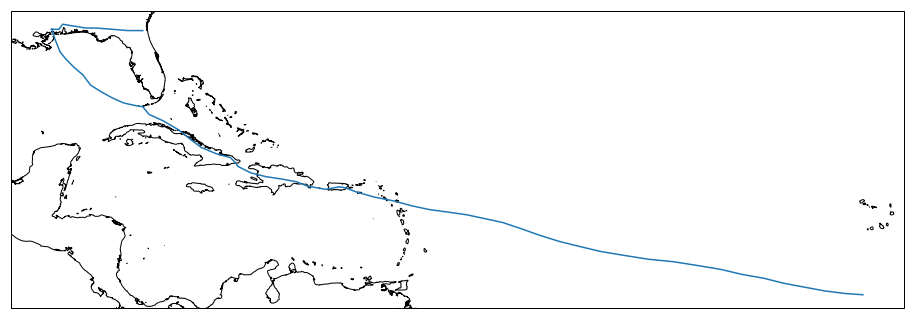

In [57]:
fig, ax = plt.subplots(1, 1, figsize=(16, 16), subplot_kw={'projection': ccrs.PlateCarree()})
ax.plot(georges.lon_wmo[georges.lon_wmo.notnull()], georges.lat_wmo[georges.lon_wmo.notnull()])
ax.coastlines('10m')

"Hurricane Georges" is a very good match. Disasters encoded as "Hurricane Grorges" appear to be mislabeled.

In [59]:
plausibly_hurricanes['Title'] = plausibly_hurricanes.Title.str.replace('GRORGES', 'GEORGES')

In [60]:
assign_ibtracs_id(georges)

In [61]:
assigned_so_far = plausibly_hurricanes[plausibly_hurricanes.ibtracs_storm_id.notnull()]
len(assigned_so_far)

9207

### Write results to file

In [62]:
assigned_so_far.to_csv(
    'DataVizDisasterSummariesFV12.19.2016.explicitly_named_hurricanes.csv',
    index=False)

In [63]:
not_assigned_hurricanes = (
    plausibly_hurricanes[
        np.isin(plausibly_hurricanes['Incident Type'], ['Hurricane', 'Severe Storm', 'Coastal Storm'])
        & plausibly_hurricanes.ibtracs_storm_id.notnull()])

In [66]:
(
    len(not_assigned_hurricanes),
    len(not_assigned_hurricanes['Disaster Number'].drop_duplicates()),
    len(not_assigned_hurricanes['declaration_date'].drop_duplicates()))

(9207, 327, 228)

# Filter by proximity to known storms

# Assign shapefiles

In [67]:
county_shapes = gpd.read_file(
    '/gcs/rhg-data/impactlab-rhg/spatial/shapefiles/source/us_census/cbf_counties/cb_2017_us_county_500k.shp')

county_shapes = county_shapes.set_index(county_shapes.GEOID.astype(int))

In [68]:
county_shapes = county_shapes.set_index(county_shapes.GEOID.astype(int)).geometry

In [69]:
state_shapes = gpd.read_file(
    '/gcs/rhg-data/impactlab-rhg/spatial/shapefiles/source/us_census/us_state/cb_2017_us_state_500k.shp')

state_shapes = state_shapes.set_index(state_shapes.STATEFP.astype(int))

### assign shapes

In [70]:
plausibly_hurricanes['geometry'] = np.nan

In [71]:
states_mask = ((plausibly_hurricanes.state_fips.notnull()) 
    & (plausibly_hurricanes.county_fips.isnull() | (plausibly_hurricanes.State == 'District of Columbia')))

county_mask = (
    plausibly_hurricanes.county_fips.notnull()
    & (plausibly_hurricanes.State != 'District of Columbia'))

In [73]:
states_mask.sum(), county_mask.sum()

(149, 30541)

In [74]:
counties = plausibly_hurricanes[(
    plausibly_hurricanes.county_fips.notnull()
    & (plausibly_hurricanes.State != 'District of Columbia'))].fips.unique().astype(int)

In [75]:
states = (
    plausibly_hurricanes[(
        plausibly_hurricanes.county_fips.isnull()
        | (plausibly_hurricanes.State == 'District of Columbia'))]
    .state_fips
    .unique()
    .astype(int))

In [77]:
counties[~np.isin(counties, county_shapes.index)]

array([], dtype=int64)

In [78]:
np.isin(states, state_shapes.index).all()

True

In [79]:
plausibly_hurricanes.loc[states_mask, 'geometry'] = (
    state_shapes.reindex(plausibly_hurricanes.loc[states_mask, 'state_fips']).geometry.values)

I am densified (external_values, 149 elements)


In [80]:
plausibly_hurricanes.loc[county_mask, 'geometry'] = (
    county_shapes.reindex(plausibly_hurricanes.loc[county_mask, 'fips']).geometry.values)

I am densified (external_values, 30541 elements)


In [81]:
plausibly_hurricanes.head()

,Disaster Number,Year,Region,Region Number,State Abbreviation,State,County,Declaration Date,Disaster Type,Incident Type,...,Disaster Close Out Date,fips,state_fips,county_fips,school_district,declaration_date,ibtracs_storm_id,ibtracs_storm_name,ibtracs_storm_season,geometry
0,3,1953,Region VI,6,LA,Louisiana,Statewide,5/29/53,DR,Flood,...,2/1/60,22000.0,22,NaN,NaN,1953-05-29 18:00:00,NaN,NaN,NaN,"(POLYGON ((-88.8677 29.861551, -88.86565899999..."
4,25,1954,Region I,1,CT,Connecticut,Statewide,9/17/54,DR,Hurricane,...,1/1/57,9000.0,9,NaN,NaN,1954-09-17 18:00:00,NaN,NaN,NaN,"(POLYGON ((-72.761427 41.242333, -72.759733 41..."
5,35,1955,Region VI,6,OK,Oklahoma,Statewide,6/1/55,DR,Flood,...,12/1/59,40000.0,40,NaN,NaN,1955-06-01 18:00:00,NaN,NaN,NaN,"POLYGON ((-103.002565 36.526588, -103.002188 3..."
7,45,1955,Region II,2,NY,New York,Statewide,8/22/55,DR,Hurricane,...,2/1/57,36000.0,36,NaN,NaN,1955-08-22 18:00:00,NaN,NaN,NaN,"(POLYGON ((-72.0368298202051 41.2498425393847,..."
11,95,1959,Region VI,6,OK,Oklahoma,Statewide,11/9/59,DR,Flood,...,5/19/61,40000.0,40,NaN,NaN,1959-11-09 18:00:00,NaN,NaN,NaN,"POLYGON ((-103.002565 36.526588, -103.002188 3..."


## Match shapes & dates with storms

In [84]:
sample = ibtracs.loc[{'storm': (ibtracs.name == b'IRENE')}].isel(storm=-1)
sample

<xarray.Dataset>
Dimensions:        (time: 137)
Coordinates:
    storm          int64 6858
  * time           (time) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
Data variables:
    storm_sn       |S13 b'2011233N15301'
    name           |S5 b'IRENE'
    numObs         int16 43
    season         int16 2011
    track_type     int8 0
    genesis_basin  int8 0
    num_basins     int8 1
    basin          (time) float32 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    time_wmo       (time) datetime64[ns] 2011-08-21T00:00:00.000043008 ...
    lat_wmo        (time) float32 15.0 16.0 16.8 17.5 17.8 17.9 18.1 ...
    lon_wmo        (time) float32 -59.0 -60.6 -62.199997 -63.699997 -64.6 ...
    alt            (time) float32 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    wind_wmo       (time) float32 45.0 45.0 45.0 50.0 60.0 60.0 60.0 65.0 ...
    pres_wmo       (time) float32 1006.0 1006.0 1005.0 999.0 993.0 993.0 ...
    sub_basin      (time) float32 0.0 12.0 12.0 12.0 12.0 12.0 12.0

In [85]:
time_min, time_max = sample.time_wmo.values.min(), sample.time_wmo.values.max()
time_min, time_max

(numpy.datetime64('2011-08-21T00:00:00.000043008'),
 numpy.datetime64('2011-08-30T00:00:00.000043008'))

In [86]:
import shapely
import shapely.ops
import shapely.vectorized

In [87]:
sample.lon_wmo[sample.lon_wmo.notnull()]

<xarray.DataArray 'lon_wmo' (time: 43)>
array([-59.      , -60.6     , -62.199997, -63.699997, -64.6     , -65.      ,
       -65.799995, -65.9     , -67.      , -68.      , -68.799995, -69.7     ,
       -70.6     , -71.2     , -71.9     , -72.5     , -73.299995, -74.      ,
       -74.299995, -75.1     , -75.9     , -76.2     , -76.6     , -77.2     ,
       -77.299995, -77.299995, -77.4     , -77.5     , -77.1     , -76.799995,
       -76.6     , -76.299995, -75.7     , -75.      , -74.4     , -74.1     ,
       -74.      , -73.1     , -72.1     , -69.5     , -66.7     , -63.8     ,
       -60.      ], dtype=float32)
Coordinates:
    storm    int64 6858
  * time     (time) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
Attributes:
    long_name:  Storm center longitude
    units:      degrees_east

In [88]:
path = shapely.geometry.LineString(
    list(zip(sample.lon_wmo[sample.lon_wmo.notnull()].values, sample.lat_wmo[sample.lon_wmo.notnull()].values)))

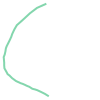

In [89]:
path

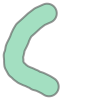

In [90]:
buffered_track = path.buffer(5)
buffered_track

In [91]:
possibly_irene = plausibly_hurricanes[((plausibly_hurricanes.declaration_date >= time_min)
        & (plausibly_hurricanes.declaration_date <= time_max))]

In [92]:
(
    possibly_irene[['Incident Type', 'Title', 'State', 'County']]
    [np.vectorize(buffered_track.intersects)(possibly_irene.geometry.values)])

,Incident Type,Title,State,County
20611,Hurricane,HURRICANE IRENE,Virginia,Gloucester County
20612,Hurricane,HURRICANE IRENE,Virginia,Williamsburg city
20613,Hurricane,HURRICANE IRENE,Pennsylvania,Pike County
20616,Hurricane,HURRICANE IRENE,Virginia,King George County
20617,Hurricane,HURRICANE IRENE,Massachusetts,Dukes County
33262,Hurricane,HURRICANE IRENE,North Carolina,Bertie County
33263,Hurricane,HURRICANE IRENE,North Carolina,Edgecombe County
33264,Hurricane,HURRICANE IRENE,North Carolina,Nash County
33265,Hurricane,HURRICANE IRENE,New York,Orange County
33266,Hurricane,HURRICANE IRENE,North Carolina,Washington County


In [169]:
def plot_potential_matches(storm, buffer=5):
    
    storm_id = storm.storm.item()

    time_min, time_max = storm.time_wmo.values.min(), storm.time_wmo.values.max()

    path = shapely.geometry.LineString(
        list(zip(
            storm.lon_wmo[storm.lon_wmo.notnull()].values,
            storm.lat_wmo[storm.lon_wmo.notnull()].values)))

    buffered_track = path.buffer(buffer)

    possible_matches = plausibly_hurricanes[((plausibly_hurricanes.declaration_date >= time_min)
            & (plausibly_hurricanes.declaration_date <= time_max + np.timedelta64(90, 'D')))]
    
    if len(possible_matches) == 0:
        return

    fig, ax = plt.subplots(1, 1, figsize=(20, 20), subplot_kw={'projection': ccrs.PlateCarree()})

    ax.plot(buffered_track.boundary.xy[0], buffered_track.boundary.xy[1])

    withins = np.vectorize(buffered_track.intersects)(possible_matches.geometry.values)

    ax.coastlines('10m')

    def update_bounds(shape):
        (minx, miny, maxx, maxy) = shape.bounds
        x0, x1, y0, y1 = ax.get_extent()
        ax.set_extent([min(minx, x0), max(maxx, x1), min(miny, y0), max(maxy, y1)])

    for i in range(possible_matches.shape[0]):
        if (possible_matches.ibtracs_storm_id.iloc[i] == storm_id):
            if withins[i]:
                color = 'green'
            else:
                color = 'red'
        elif withins[i]:
            color='blue'
        else:
            color='yellow'

        geom = possible_matches.geometry.values[i]
        patch = PolygonPatch(geom, facecolor=color, alpha=0.3)
        ax.add_patch(patch)
        update_bounds(geom)

In [95]:
katrina = ibtracs.loc[{'storm': (ibtracs.name == b'KATRINA')}].isel(storm=-1)
katrina

<xarray.Dataset>
Dimensions:        (time: 137)
Coordinates:
    storm          int64 6322
  * time           (time) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
Data variables:
    storm_sn       |S13 b'2005236N23285'
    name           |S7 b'KATRINA'
    numObs         int16 34
    season         int16 2005
    track_type     int8 0
    genesis_basin  int8 0
    num_basins     int8 1
    basin          (time) float32 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    time_wmo       (time) datetime64[ns] 2005-08-23T18:00:00.000043008 ...
    lat_wmo        (time) float32 23.1 23.4 23.8 24.5 25.4 26.0 26.099998 ...
    lon_wmo        (time) float32 -75.1 -75.7 -76.2 -76.5 -76.9 -77.7 -78.4 ...
    alt            (time) float32 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    wind_wmo       (time) float32 30.0 30.0 30.0 35.0 40.0 45.0 50.0 55.0 ...
    pres_wmo       (time) float32 1008.0 1007.0 1007.0 1006.0 1003.0 1000.0 ...
    sub_basin      (time) float32 0.0 0.0 0.0 0.0 0.0 0

In [310]:
plausibly_hurricanes[
    ((plausibly_hurricanes['State Abbreviation'] == 'NE')
     & (plausibly_hurricanes.ibtracs_storm_name == 'KATRINA'))].Title

30424    HURRICANE KATRINA EVACUEES
30425    HURRICANE KATRINA EVACUEES
30426    HURRICANE KATRINA EVACUEES
30427    HURRICANE KATRINA EVACUEES
30428    HURRICANE KATRINA EVACUEES
30429    HURRICANE KATRINA EVACUEES
30430    HURRICANE KATRINA EVACUEES
30431    HURRICANE KATRINA EVACUEES
30432    HURRICANE KATRINA EVACUEES
30433    HURRICANE KATRINA EVACUEES
30459    HURRICANE KATRINA EVACUEES
30460    HURRICANE KATRINA EVACUEES
30461    HURRICANE KATRINA EVACUEES
30462    HURRICANE KATRINA EVACUEES
30463    HURRICANE KATRINA EVACUEES
30464    HURRICANE KATRINA EVACUEES
30465    HURRICANE KATRINA EVACUEES
30466    HURRICANE KATRINA EVACUEES
30467    HURRICANE KATRINA EVACUEES
30468    HURRICANE KATRINA EVACUEES
30494    HURRICANE KATRINA EVACUEES
30495    HURRICANE KATRINA EVACUEES
30496    HURRICANE KATRINA EVACUEES
30497    HURRICANE KATRINA EVACUEES
30498    HURRICANE KATRINA EVACUEES
30499    HURRICANE KATRINA EVACUEES
30500    HURRICANE KATRINA EVACUEES
30501    HURRICANE KATRINA E

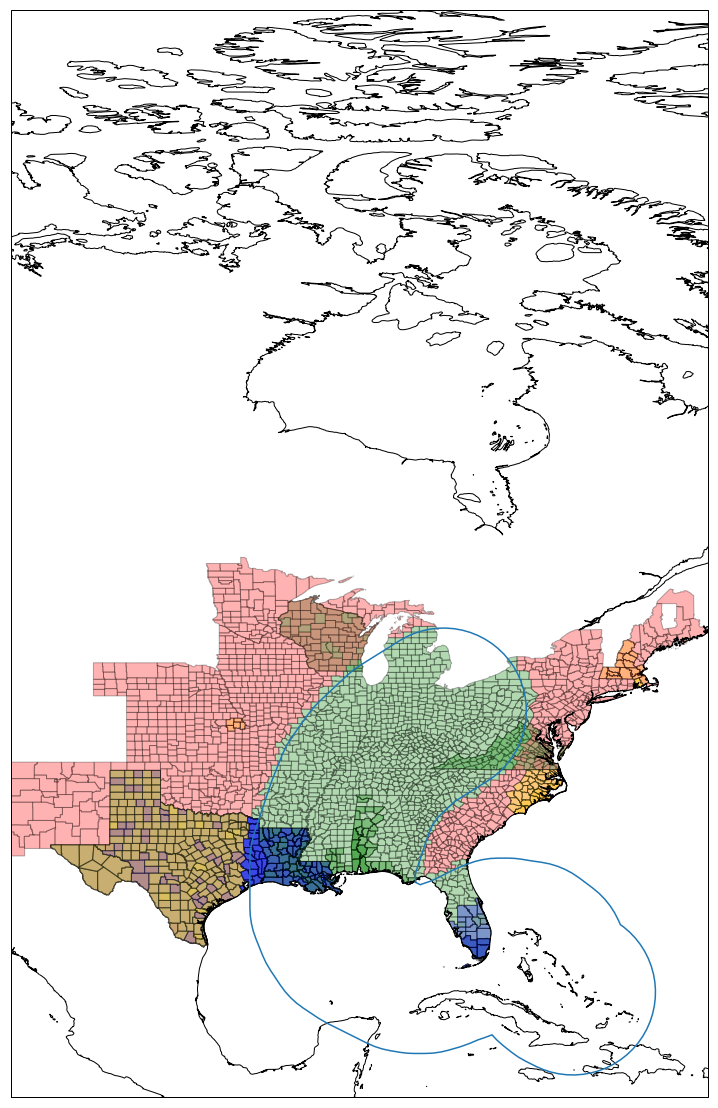

In [97]:
plot_potential_matches(katrina, buffer=5)

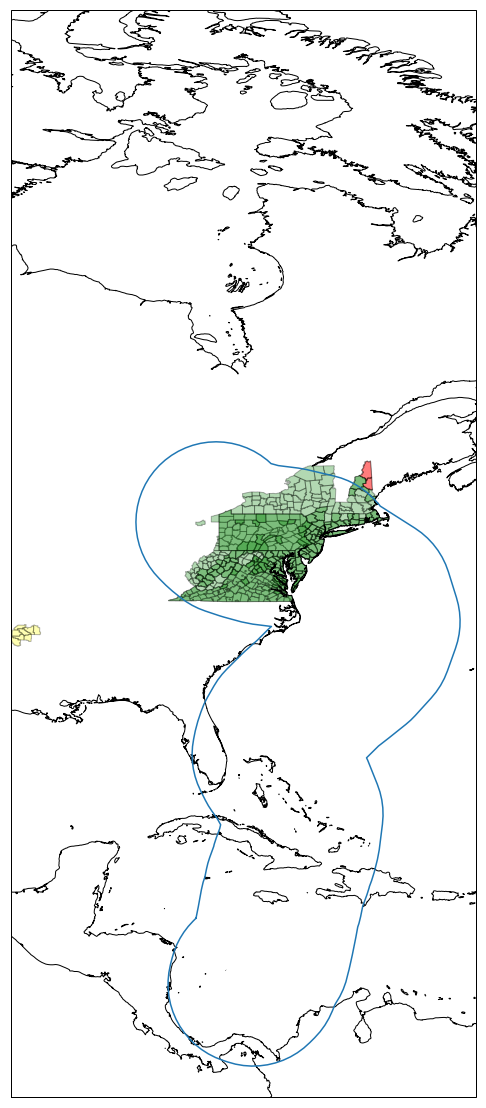

In [99]:
storm = ibtracs.loc[{'storm': ((ibtracs.name == b'SANDY') & (ibtracs.season == 2012))}].isel(storm=0)
plot_potential_matches(storm, buffer=5)

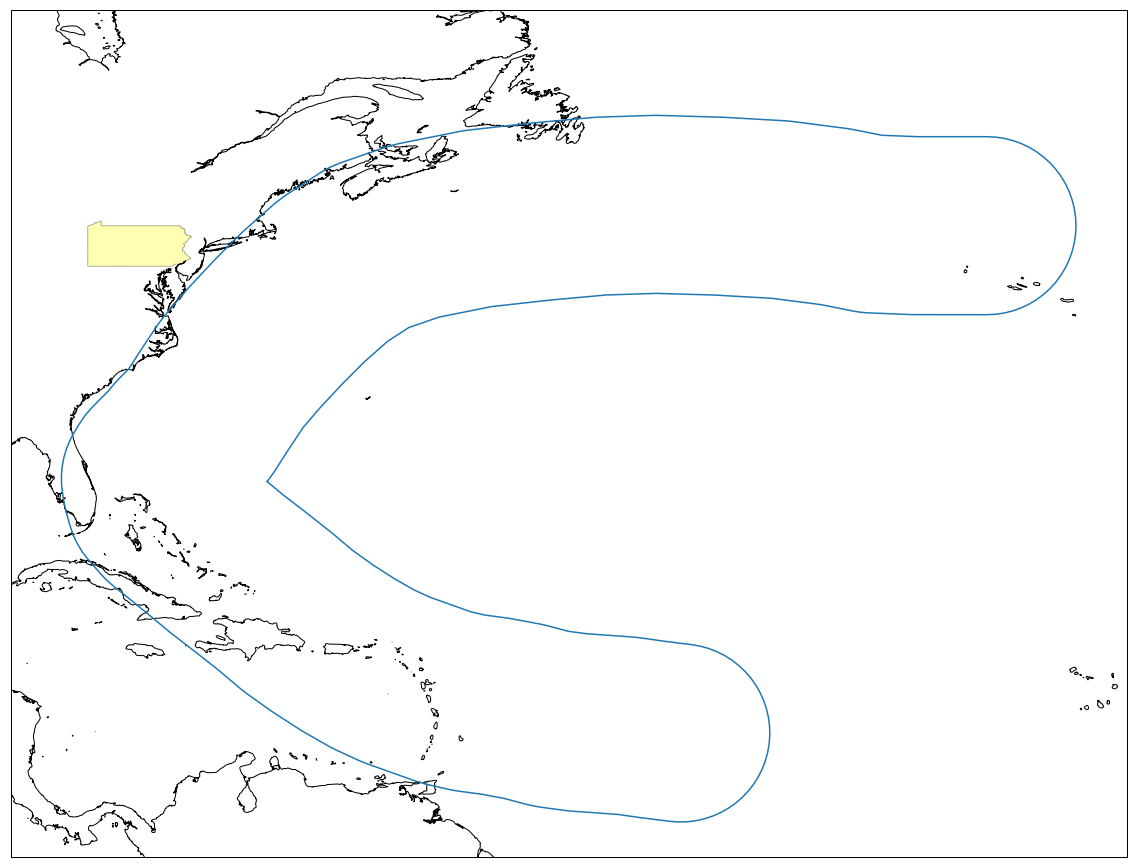

In [286]:
bob = atlantic.loc[{'storm': ((atlantic.name == b'BETSY') & (atlantic.season == 1956))}].isel(storm=0)
plot_potential_matches(bob, buffer=5)

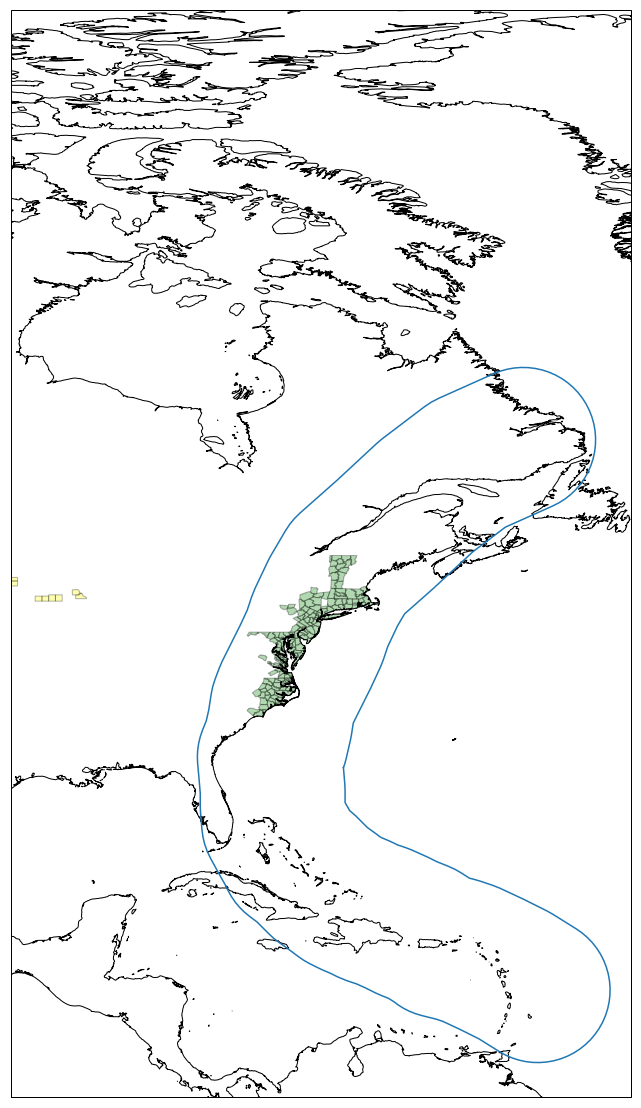

In [288]:
bob = atlantic.loc[{'storm': ((atlantic.name == b'IRENE') & (atlantic.season == 2011))}].isel(storm=0)
plot_potential_matches(bob, buffer=5)

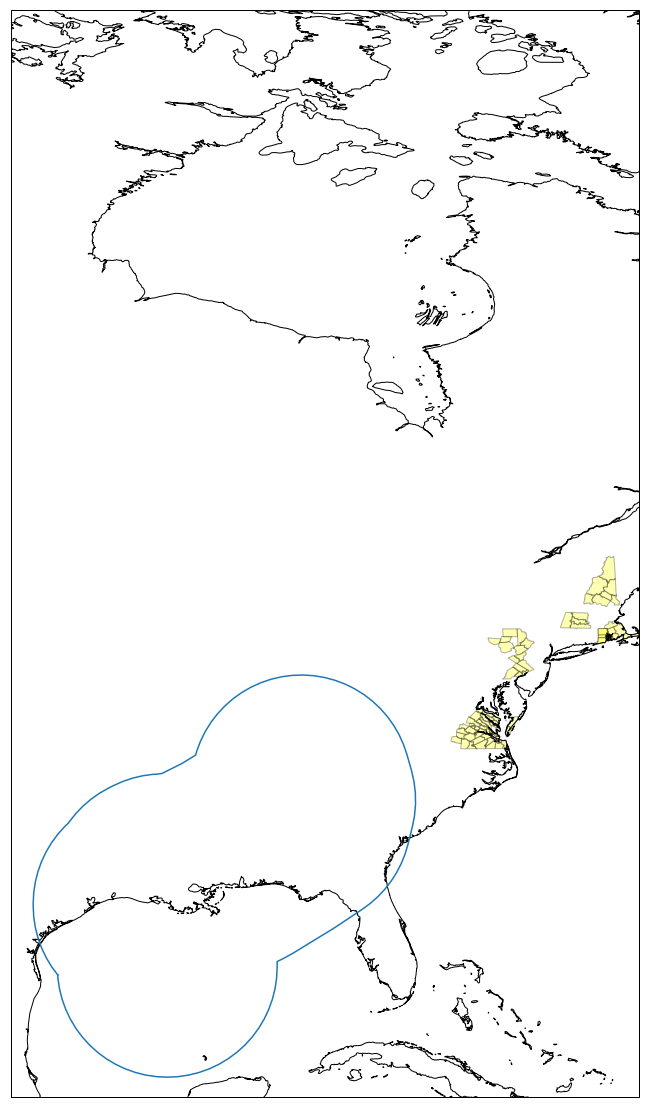

In [289]:
bob = atlantic.loc[{'storm': ((atlantic.name == b'LEE') & (atlantic.season == 2011))}].isel(storm=0)
plot_potential_matches(bob, buffer=5)

In [293]:
atlantic.loc[{'storm': ((atlantic.name == b'ISIDORE'))}]

<xarray.Dataset>
Dimensions:        (storm: 4, time: 137)
Coordinates:
  * storm          (storm) int64 4384 4934 5505 6047
  * time           (time) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
Data variables:
    storm_sn       (storm) |S13 b'1984270N23287' b'1990247N07337' ...
    name           (storm) |S57 b'ISIDORE' b'ISIDORE' b'ISIDORE' b'ISIDORE'
    numObs         (storm) int16 25 55 33 55
    season         (storm) int16 1984 1990 1996 2002
    track_type     (storm) int8 0 0 0 0
    genesis_basin  (storm) int8 0 0 0 0
    num_basins     (storm) int8 1 1 1 1
    basin          (storm, time) float32 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    time_wmo       (storm, time) datetime64[ns] 1984-09-25T12:00:00.000043520 ...
    lat_wmo        (storm, time) float32 23.4 23.9 24.3 24.5 24.699999 25.0 ...
    lon_wmo        (storm, time) float32 -73.0 -73.9 -74.9 -76.0 -77.0 -77.7 ...
    alt            (storm, time) float32 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    wind_wm

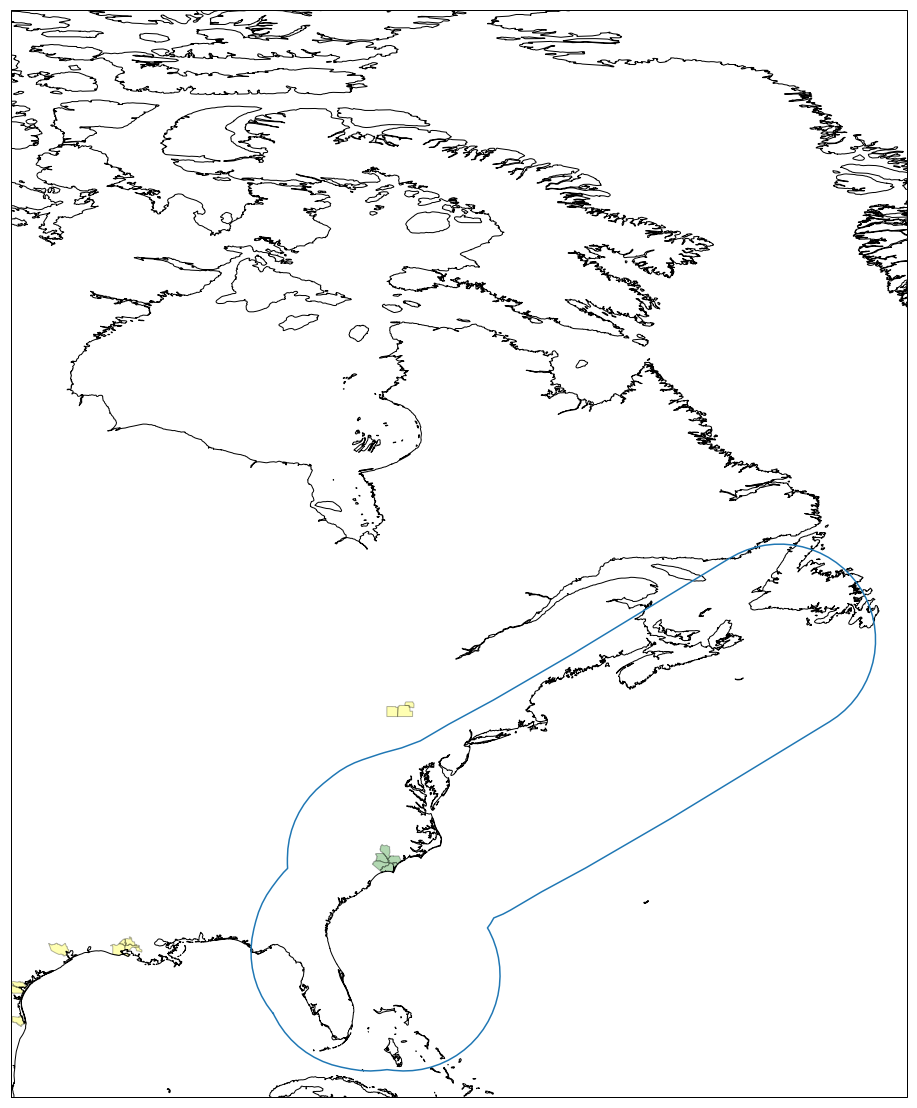

In [103]:
storm = ibtracs.loc[{'storm': ((ibtracs.name == b'DIANA') & (ibtracs.season == 1984))}].isel(storm=0)
plot_potential_matches(storm, buffer=5)

## Assign potential storm matches based on time & location

In [105]:
plausibly_hurricanes['hurricanes_occurring_within_90_days'] = np.nan
plausibly_hurricanes['hurricanes_occurring_within_90_days_and_4_degrees'] = np.nan
plausibly_hurricanes['best_guess_hurricane_ibtracs_storm_id'] = plausibly_hurricanes.ibtracs_storm_id
plausibly_hurricanes['best_guess_hurricane_ibtracs_storm_name'] = plausibly_hurricanes.ibtracs_storm_name
plausibly_hurricanes['best_guess_hurricane_ibtracs_storm_season'] = plausibly_hurricanes.ibtracs_storm_season

In [109]:
ibtracs.storm

<xarray.DataArray 'storm' (storm: 7367)>
array([   0,    1,    2, ..., 7364, 7365, 7366])
Coordinates:
  * storm    (storm) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...

In [107]:
storms_not_in_data = ibtracs.storm[~np.isin(ibtracs.storm, plausibly_hurricanes.ibtracs_storm_id)]
storms_not_in_data

<xarray.DataArray 'storm' (storm: 7276)>
array([   0,    1,    2, ..., 7364, 7365, 7366])
Coordinates:
  * storm    (storm) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...

In [160]:
plausibly_hurricanes[(
    (plausibly_hurricanes.ibtracs_storm_name == 'UNNAMED')
    & (plausibly_hurricanes.ibtracs_storm_season == 1982))]

,Disaster Number,Year,Region,Region Number,State Abbreviation,State,County,Declaration Date,Disaster Type,Incident Type,...,declaration_date,ibtracs_storm_id,ibtracs_storm_name,ibtracs_storm_season,geometry,hurricanes_occurring_within_90_days,hurricanes_occurring_within_90_days_and_4_degrees,best_guess_hurricane_ibtracs_storm_id,best_guess_hurricane_ibtracs_storm_name,best_guess_hurricane_ibtracs_storm_season


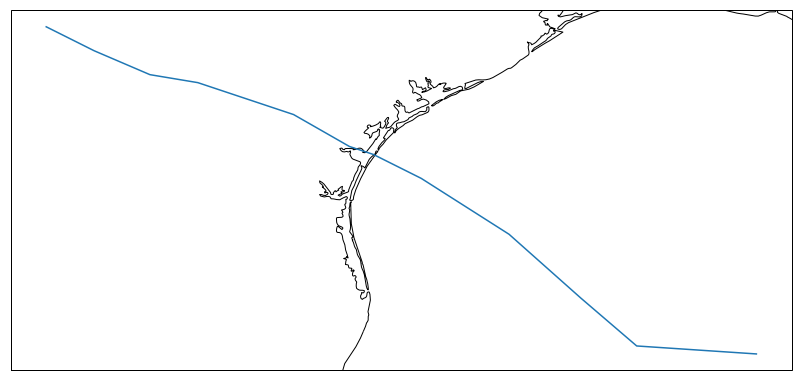

In [165]:
storms = ibtracs[{'storm': (
    (ibtracs.season == 1998)
    & (ibtracs.name == b'CHARLEY')
    & (ibtracs.time_wmo.min(dim='time').dt.dayofyear <= pd.to_datetime('1998-08-21').dayofyear)
    & (ibtracs.time_wmo.max(dim='time').dt.dayofyear >= pd.to_datetime('1998-08-24').dayofyear)
)}]

if len(storms.storm) == 0:
    print('no storms found')
elif len(storms.storm) > 1:
    print(storms)
else:
    storm = storms.isel(storm=0)
    
    fig, ax = plt.subplots(1,1, figsize=(14, 14), subplot_kw={'projection': ccrs.PlateCarree()})
    ax.plot(storm.lon_wmo, storm.lat_wmo)
    ax.coastlines('10m')


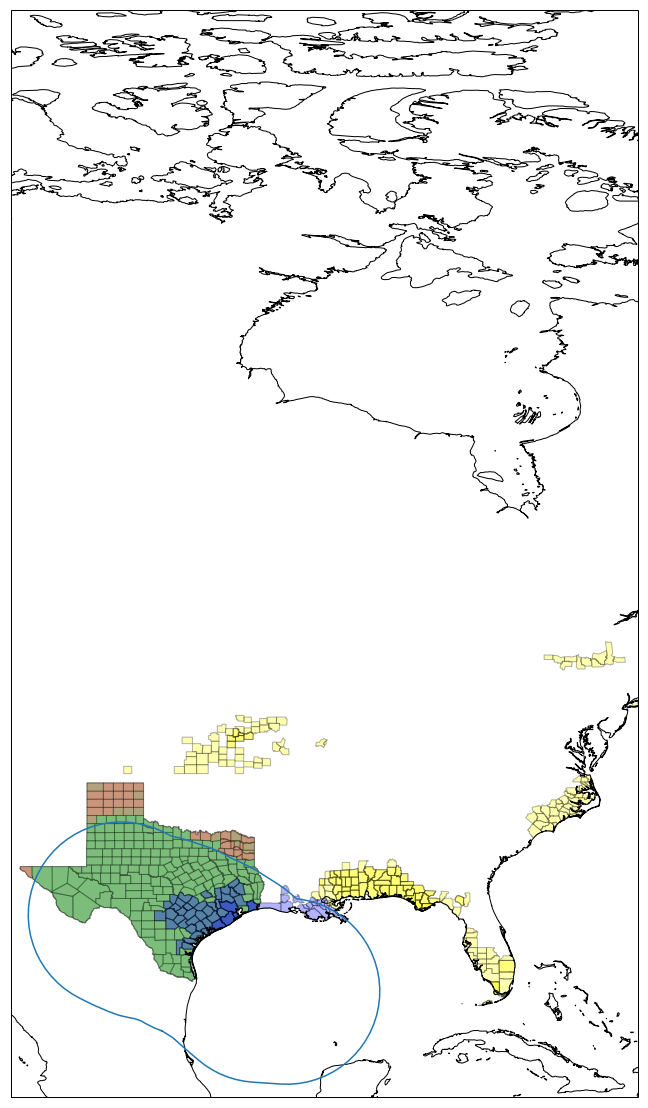

In [166]:
plot_potential_matches(storm)

In [171]:
plausibly_hurricanes.head()

,Disaster Number,Year,Region,Region Number,State Abbreviation,State,County,Declaration Date,Disaster Type,Incident Type,...,declaration_date,ibtracs_storm_id,ibtracs_storm_name,ibtracs_storm_season,geometry,hurricanes_occurring_within_90_days,hurricanes_occurring_within_90_days_and_4_degrees,best_guess_hurricane_ibtracs_storm_id,best_guess_hurricane_ibtracs_storm_name,best_guess_hurricane_ibtracs_storm_season
0,3,1953,Region VI,6,LA,Louisiana,Statewide,5/29/53,DR,Flood,...,1953-05-29 18:00:00,NaN,NaN,NaN,"(POLYGON ((-88.8677 29.861551, -88.86565899999...",NaN,NaN,NaN,NaN,NaN
4,25,1954,Region I,1,CT,Connecticut,Statewide,9/17/54,DR,Hurricane,...,1954-09-17 18:00:00,NaN,NaN,NaN,"(POLYGON ((-72.761427 41.242333, -72.759733 41...",NaN,NaN,NaN,NaN,NaN
5,35,1955,Region VI,6,OK,Oklahoma,Statewide,6/1/55,DR,Flood,...,1955-06-01 18:00:00,NaN,NaN,NaN,"POLYGON ((-103.002565 36.526588, -103.002188 3...",NaN,NaN,NaN,NaN,NaN
7,45,1955,Region II,2,NY,New York,Statewide,8/22/55,DR,Hurricane,...,1955-08-22 18:00:00,NaN,NaN,NaN,"(POLYGON ((-72.0368298202051 41.2498425393847,...",NaN,NaN,NaN,NaN,NaN
11,95,1959,Region VI,6,OK,Oklahoma,Statewide,11/9/59,DR,Flood,...,1959-11-09 18:00:00,NaN,NaN,NaN,"POLYGON ((-103.002565 36.526588, -103.002188 3...",NaN,NaN,NaN,NaN,NaN


In [168]:
def find_potential_matches(storm, buffer=5):

    storm_id = storm.storm.item()

    time_min, time_max = storm.time_wmo.values.min(), storm.time_wmo.values.max()

    path = shapely.geometry.LineString(
        list(zip(
            storm.lon_wmo[storm.lon_wmo.notnull()].values,
            storm.lat_wmo[storm.lon_wmo.notnull()].values)))

    buffered_track = path.buffer(buffer)

    possible_matches = (
        (plausibly_hurricanes.ibtracs_storm_id.isnull())
        & (plausibly_hurricanes.declaration_date >= time_min)
        & (plausibly_hurricanes.declaration_date <= time_max + np.timedelta64(90, 'D')))
    
    if not possible_matches.any():
        return None, None

    withins = np.vectorize(buffered_track.intersects)(possible_matches.geometry.values)
    
    return possible_matches[withins], possible_matches[~withins]

In [170]:
matched, not_matched = find_potential_matches(storm)
matched

AttributeError: 'Series' object has no attribute 'geometry'